# Cats and Dogs Classification using CNN & Transfer Learning

## Import needed libraries

In [1]:
import os
import shutil
from zipfile import ZipFile
import random


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

## Loading and preparing the Images

In [ ]:
absolute_path = os.path.dirname(__file__)

data_path = os.path.join(absolute_path)

In [ ]:
#Unzipping the file
data = data_path + "\train.zip"

with ZipFile(data,'r') as f:
    f.extractall()
    print("Done")

In [2]:
path,dirs,files = next(os.walk((data_path ,'\train'))
print(f"Number of Imgs are {len(files)}")

Number of Imgs are 25000


In [ ]:
#Create a new directory for resized Images 
os.mkdir(data_path ,'\resized')

In [3]:
origin_path = data_path + "\train\\"
resized_path = data_path + "\resized\\"

In [ ]:
#I resized the photos to (224,224), but I was unable to run CNN with 4000 images.
#Therefore, I resize the image to (64,64) for my CNN and (224,224) for the pretrained model.

#resizing pictures to (64,64)

#This loop will resize and convert each image to RGB before saving it in the directory.
for i in range(len(files)):
    filename = os.listdir(origin_path)[i]
    img_path = origin_path + filename
    
    img = Image.open(img_path)
    img = img.resize((64,64))
    img = img.convert('RGB')
    
    new_path =  resized_path + filename
    img.save(new_path)

In [ ]:
#creating two directories for resized cats and dogs.
os.mkdir(data_path , '\resized_cats')
os.mkdir(data_path , '\resized_dogs')

In [4]:
cat_dir= data_path + '\resized_cats'
dog_dir= data_path + '\resized_dogs'

In [ ]:
#I am attempting to split the images like we did in class in in order to separate them in the future.
#This loop will check the resized folder and save images whose names begin with
#"Dog" and "Cat" to different directories.
for folders , subfolders, filenames in os.walk(resized_path):
    for filename in filenames:
        if filename.startswith(f"{'dog'}"):
            shutil.copy(os.path.join(folders,filename), dog_dir)
        else:
            shutil.copy(os.path.join(folders,filename), cat_dir)

## CNN

#### After preparing the folders containing the images, it is time to begin preprocessing.

In [5]:
path = data_path + '\resized_64'

In [6]:
def load_dataset(data_path:str, img_number:int) -> tuple:
    '''
    Loading the dataset
    inputs
        -Dataset path
        -number of images
    output
        -number of images
        -Label (0 for Cat and 1 for Dog)
    '''
    cat_dir = os.path.join(data_path, "\resized_cats")
    dog_dir = os.path.join(data_path, "\resized_dogs")
    
    cat_img_path = [os.path.join(root,path) for root,dirs,files in os.walk(cat_dir) for path in files]
    dog_img_path = [os.path.join(root,path) for root,dirs,files in os.walk(dog_dir) for path in files]
    
    if img_number:
        cat_img_path = cat_img_path[:img_number]
        dog_img_path = dog_img_path[:img_number]
    
    img_paths = cat_img_path + dog_img_path
    labels = [0] * len (cat_img_path) + [1] * len(dog_img_path)
    return([img_path for img_path in img_paths], labels)

In [8]:
#We have selected 5000 images from each directory with the label created in the function.
images, labels = load_dataset(path,10000)

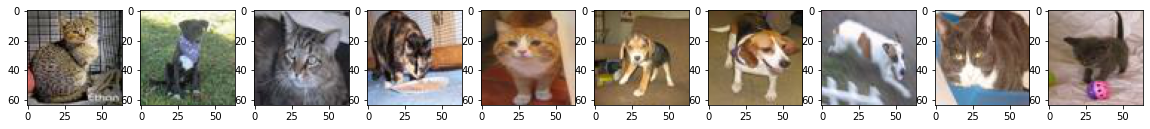

In [9]:
#Visualize random 10 images
rand = [random.choice(images) for i in range(10)]

fig, ax = plt.subplots(1,10,figsize=(20,15))
ax = ax.ravel() # flaten the matrix into array

for i in range (0, 10): 
    image = mpimg.imread(rand[i])
    ax[i].imshow(image)

In [10]:
#Convert all the images into a np array
dog_cat_images_64 = np.asarray([cv2.imread(file) for file in images])

In [11]:
dog_cat_images_64

array([[[[ 88, 164, 206],
         [ 93, 169, 211],
         [101, 177, 219],
         ...,
         [139, 216, 243],
         [135, 211, 240],
         [132, 210, 239]],

        [[ 92, 168, 210],
         [ 97, 173, 215],
         [104, 180, 222],
         ...,
         [139, 216, 243],
         [136, 212, 241],
         [133, 211, 240]],

        [[ 92, 168, 210],
         [ 98, 174, 216],
         [105, 181, 223],
         ...,
         [140, 217, 244],
         [137, 213, 242],
         [135, 213, 242]],

        ...,

        [[ 49, 125, 161],
         [ 58, 132, 168],
         [ 63, 135, 169],
         ...,
         [  0,   5,   4],
         [  0,   5,   4],
         [  0,   4,   3]],

        [[ 46, 122, 158],
         [ 57, 131, 167],
         [ 62, 134, 168],
         ...,
         [  0,   4,   3],
         [  0,   4,   3],
         [  0,   4,   3]],

        [[ 44, 120, 156],
         [ 56, 130, 164],
         [ 61, 133, 167],
         ...,
         [  0,   4,   3],
        

In [12]:
len(dog_cat_images_64)

20000

#### Preparing dependent and independent variables for splitting into train and test sets

In [13]:
X = dog_cat_images_64 
Y = np.asarray(labels)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [14]:
print(X.shape, X_train.shape, X_test.shape)

(20000, 64, 64, 3) (16000, 64, 64, 3) (4000, 64, 64, 3)


## CNN Model 

In [15]:
#Scaling the images to reduce the number of parameters so the model will be faster in training
X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [16]:
#In this model i used 3 Convolutional layers with activation function RelU

#Each convolutional layer conatins:
#    - number of filter, kernal size to specify window size, input shape and padding
#    - using (2,2) to take the max value in 2x2 window
#    - apply transformation to maintain the mean output close to 0 and output's std close to 1
#    - Dropout layers to avoid overfitting

#for the output layer i used sigmoid because we have binary classification problem


model = keras.Sequential([
    #
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3), padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),


    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0

In [18]:
# Using Adam optimizer because it can achieve the minimum cost more quickly 
#  by taking larger steps than other optimizers.
# for the loss, I choose binary crossentropy because I have a problem of classification (two targted classes)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [19]:
history_CNN = model.fit(X_train_scaled, Y_train, epochs=25,validation_split=0.2,callbacks=[callback])

Epoch 1/25
400/400 [==============================] - 25s 60ms/step - loss: 0.6352 - accuracy: 0.6555 - val_loss: 0.8131 - val_accuracy: 0.5853
Epoch 2/25
400/400 [==============================] - 24s 59ms/step - loss: 0.5293 - accuracy: 0.7371 - val_loss: 0.5791 - val_accuracy: 0.6950
Epoch 3/25
400/400 [==============================] - 24s 59ms/step - loss: 0.4701 - accuracy: 0.7740 - val_loss: 0.8174 - val_accuracy: 0.5809
Epoch 4/25
400/400 [==============================] - 24s 59ms/step - loss: 0.4144 - accuracy: 0.8087 - val_loss: 0.6774 - val_accuracy: 0.7131
Epoch 5/25
400/400 [==============================] - 25s 62ms/step - loss: 0.3534 - accuracy: 0.8442 - val_loss: 0.4831 - val_accuracy: 0.7828
Epoch 6/25
400/400 [==============================] - 24s 60ms/step - loss: 0.2938 - accuracy: 0.8725 - val_loss: 0.7771 - val_accuracy: 0.7197
Epoch 7/25
400/400 [==============================] - 24s 59ms/step - loss: 0.2403 - accuracy: 0.8981 - val_loss: 0.6022 - val_accuracy:

In [20]:
#Checking for accuracy for the validation set

score, acc = model.evaluate(X_test_scaled, Y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

125/125 [==============================] - 2s 15ms/step - loss: 1.1693 - accuracy: 0.7595
Test Loss = 1.1692625284194946
Test Accuracy = 0.7595000267028809


In [21]:
history_CNN.history

{'loss': [0.6351889967918396,
  0.5292985439300537,
  0.4700753092765808,
  0.41439545154571533,
  0.3533708453178406,
  0.29377004504203796,
  0.24032741785049438,
  0.18587005138397217,
  0.14597181975841522,
  0.11539158225059509,
  0.1090630441904068,
  0.08903653919696808,
  0.07311584800481796,
  0.06844601035118103,
  0.06398032605648041,
  0.04714794456958771,
  0.049872346222400665,
  0.059244826436042786,
  0.0365702249109745,
  0.03378831222653389,
  0.037249211221933365,
  0.050624098628759384,
  0.048425279557704926],
 'accuracy': [0.6555469036102295,
  0.737109363079071,
  0.7739843726158142,
  0.8087499737739563,
  0.8442187309265137,
  0.8725000023841858,
  0.8981249928474426,
  0.9270312786102295,
  0.9410937428474426,
  0.9564843773841858,
  0.9588281512260437,
  0.9657812714576721,
  0.9737499952316284,
  0.9737499952316284,
  0.9771875143051147,
  0.9826562404632568,
  0.9813281297683716,
  0.9779687523841858,
  0.9873437285423279,
  0.9892187714576721,
  0.98742187

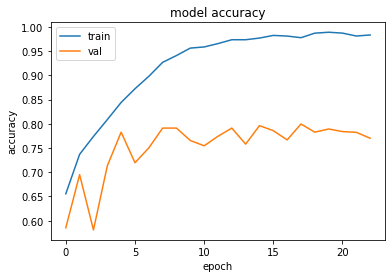

In [22]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

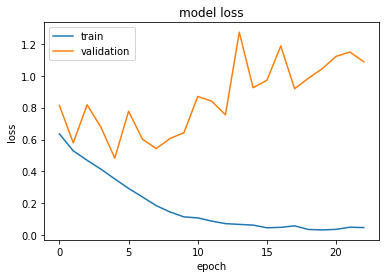

In [23]:
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Transfer Learning

In [24]:
images_path_22 = data_path + '\resized_224'

In [25]:
# Since the image sizes are (224,224) so it's going to be hard to process on my laptop
#I chose 3000 image from each class
images, labels = load_dataset(images_path_22,3000)

In [26]:
dog_cat_images_224 = np.asarray([cv2.imread(file) for file in images])

In [27]:
len(dog_cat_images_224)

6000

In [28]:
X_224 = dog_cat_images_224
Y_224 = np.asarray(labels)
X_train_224, X_test_224, Y_train_224, Y_test_224 = train_test_split(X_224, Y_224, test_size=0.2, random_state=2)

In [29]:
print(X_224.shape, X_train_224.shape, X_test_224.shape)

(6000, 224, 224, 3) (4800, 224, 224, 3) (1200, 224, 224, 3)


In [30]:
X_train_scaled_224 = X_train_224/255

X_test_scaled_224 = X_test_224/255

In [31]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [32]:
num_of_classes = 2

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
    metrics = ['acc'])

In [34]:
history_mobilenet = model.fit(X_train_scaled_224, Y_train_224, epochs=5,validation_split=0.2)

Epoch 1/5
120/120 [==============================] - 61s 471ms/step - loss: 0.1343 - acc: 0.9477 - val_loss: 0.0685 - val_acc: 0.9719
Epoch 2/5
120/120 [==============================] - 51s 423ms/step - loss: 0.0537 - acc: 0.9807 - val_loss: 0.0628 - val_acc: 0.9729
Epoch 3/5
120/120 [==============================] - 50s 416ms/step - loss: 0.0416 - acc: 0.9854 - val_loss: 0.0616 - val_acc: 0.9750
Epoch 4/5
120/120 [==============================] - 49s 410ms/step - loss: 0.0350 - acc: 0.9901 - val_loss: 0.0717 - val_acc: 0.9750
Epoch 5/5
120/120 [==============================] - 49s 405ms/step - loss: 0.0300 - acc: 0.9906 - val_loss: 0.0598 - val_acc: 0.9750


In [35]:
score, acc = model.evaluate(X_test_scaled_224, Y_test_224)
print('Test Loss =', score)
print('Test Accuracy =', acc)

38/38 [==============================] - 14s 358ms/step - loss: 0.0548 - acc: 0.9800
Test Loss = 0.05480102077126503
Test Accuracy = 0.9800000190734863


In [36]:
history_mobilenet.history

{'loss': [0.13434793055057526,
  0.05369891971349716,
  0.04155104607343674,
  0.03502354398369789,
  0.030007870867848396],
 'acc': [0.9476562738418579,
  0.9807291626930237,
  0.9854166507720947,
  0.9901041388511658,
  0.9906250238418579],
 'val_loss': [0.06846851855516434,
  0.06281725317239761,
  0.061624765396118164,
  0.07169218361377716,
  0.05982543155550957],
 'val_acc': [0.971875011920929,
  0.9729166626930237,
  0.9750000238418579,
  0.9750000238418579,
  0.9750000238418579]}

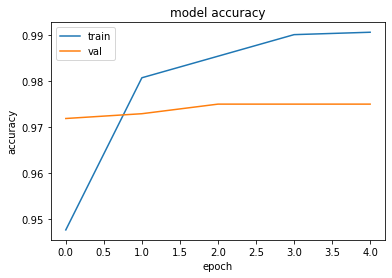

In [37]:
plt.plot(history_mobilenet.history['acc'])
plt.plot(history_mobilenet.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

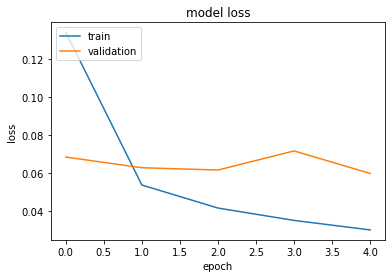

In [38]:
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 731ms/step
It's a Dog


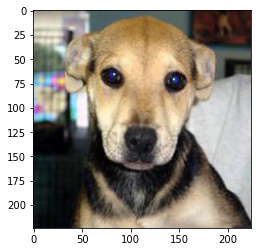

In [39]:
im = mpimg.imread(data_path , '\resized_224\resized_dogs\dog.4.jpg')

plt.imshow(im)

image_scaling = im/255

image_reshaping = np.reshape(image_scaling, [1,224,224,3])

predction = model.predict(image_reshaping)

label_pred = np.argmax(predction)

if label_pred == 0:
  print("It's a Cat")

else:
  print("It's a Dog")

1/1 [==============================] - 0s 48ms/step
It's a Cat


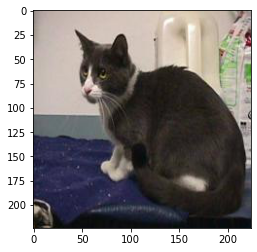

In [40]:
im = mpimg.imread(data_path , '\resized_224\resized_cats\cat.4.jpg')

plt.imshow(im)

image_scaling = im/255

image_reshaping = np.reshape(image_scaling, [1,224,224,3])

predction = model.predict(image_reshaping)

label_pred = np.argmax(predction)

if label_pred == 0:
  print("It's a Cat")

else:
  print("It's a Dog")